In [8]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [10]:
avg_train_losses, avg_test_losses, avg_difference_test_train, avg_var_grad = [], [], [], []

seeds = [12345, 1234, 123]
# seeds = [12345]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lr = 3e-6 # good one - lowest validation loss among others
    gamma = 0.7
    momentum = 0.9

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)

    train_losses, test_losses = [], []
    var_grad_list = []

    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        train_loss, grad_norms, grad_avg = train_get_grad(model, device, train_loader, optimizer, epoch, batch_size)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()

        # computing var_score over one epoch
        variance_score = compute_grad_variance(grad_norms, grad_avg)
        var_grad_list.append(variance_score)
    
    avg_train_losses.append(train_losses) 
    avg_test_losses.append(test_losses)
    avg_var_grad.append(var_grad_list)

    # print train and test losses and their difference
    difference_test_train = np.array(test_losses)  - np.array(train_losses)
    # print ("diff_test_train::\n", difference_test_train)
    avg_difference_test_train.append(difference_test_train)


seed::: 12345
54000 6000 10000

Test set: Average loss: 0.6981, Accuracy: 7524/10000 (75%)


Test set: Average loss: 0.6425, Accuracy: 7644/10000 (76%)


Test set: Average loss: 0.6270, Accuracy: 7669/10000 (77%)


Test set: Average loss: 0.6112, Accuracy: 7706/10000 (77%)


Test set: Average loss: 0.6060, Accuracy: 7718/10000 (77%)


Test set: Average loss: 0.6030, Accuracy: 7722/10000 (77%)


Test set: Average loss: 0.5963, Accuracy: 7725/10000 (77%)


Test set: Average loss: 0.5942, Accuracy: 7732/10000 (77%)


Test set: Average loss: 0.5922, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5910, Accuracy: 7737/10000 (77%)


Test set: Average loss: 0.5922, Accuracy: 7736/10000 (77%)


Test set: Average loss: 0.5896, Accuracy: 7735/10000 (77%)


Test set: Average loss: 0.5907, Accuracy: 7738/10000 (77%)


Test set: Average loss: 0.5909, Accuracy: 7736/10000 (77%)

seed::: 1234
54000 6000 10000

Test set: Average loss: 0.2462, Accuracy: 9300/10000 (93%)


Test set: Average loss:

In [11]:
print (avg_train_losses)
print (avg_test_losses)
print (avg_difference_test_train)
print (avg_var_grad)

[[0.8669650259105515, 0.6719401888725882, 0.6352557795590134, 0.6157170342043112, 0.6038529207285547, 0.5962399338941439, 0.5910820346943575, 0.5876210403774305, 0.585567649701054, 0.5837768131769946, 0.5827306121658374, 0.582005541365576, 0.5813868189521876, 0.5810276317935419], [0.4330450741671273, 0.22692347182870193, 0.18747574738910977, 0.16589540443537643, 0.15291770578083974, 0.1447532365178045, 0.1394654826539176, 0.13568470284996015, 0.13323758331555607, 0.1315378380003628, 0.13039952873194952, 0.1295450965375132, 0.1289471288948757, 0.12857737476491674], [0.42951262900296827, 0.2301675612945551, 0.19087305961626966, 0.16912163233481595, 0.1562808897408052, 0.14793733620389377, 0.14239944691076803, 0.1387860037218691, 0.13624627300719092, 0.13450777350585041, 0.13326524323850023, 0.13242018490288213, 0.1317863711928375, 0.13141734230274696]]
[[0.6981124297069137, 0.6424992758377343, 0.6269944389914252, 0.6112439436897351, 0.6060073780026406, 0.6030151225199365, 0.5963177865098

In [12]:
# Average over 3 random seeds
avg_train_losses = np.mean(np.array(avg_train_losses), 0)
avg_test_losses = np.mean(np.array(avg_test_losses), 0)
avg_difference_test_train = np.mean(np.array(avg_difference_test_train), 0)
avg_var_grad = np.mean(np.array(avg_var_grad), 0)


# print ("avg_train_losses:::\n", avg_train_losses)
# print ("avg_test_losses:::\n", avg_test_losses)
print ("average difference list::\n", avg_difference_test_train)


average difference list::
 [-0.18052125 -0.02870274 -0.01133393 -0.00555015  0.00110234  0.00352186
  0.00463652  0.00616502  0.00648042  0.00692795  0.00813759  0.00811295
  0.0090217   0.0092539 ]


In [13]:
print ("avg_var_grad::\n", avg_var_grad)

avg_var_grad::
 [2.9907715 2.5928452 2.353145  2.231897  2.1600416 2.1437852 2.075268
 2.0264657 2.0134056 2.0191548 2.009188  2.0055988 2.0121212 2.0112855]


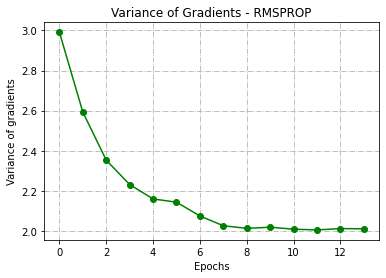

In [14]:
import numpy as np
plt.plot(np.arange(epochs), avg_var_grad, marker='o', color = "g")
plt.grid(True, linestyle='-.')
plt.title("Variance of Gradients - RMSPROP")
plt.ylabel("Variance of gradients")
plt.xlabel("Epochs")
plt.show()	  

In [18]:
a = torch.tensor([1.0,2,3,4])
print (torch.norm(a))
print (torch.norm(a), 2)

tensor(5.4772)
tensor(5.4772) 2


In [19]:
5.4772*5.4772/

29.999719839999997